Columns in listings_df:
Index(['listing_id', 'listing_url', 'name', 'description', 'latitude',
       'longitude', 'property_type', 'room_type', 'accomodates',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'host_id'],
      dtype='object')
Calendar table shape: (319192, 8)
Unique listings in Calendar: 1749
Missing values per column:
listing_id          0
bedrooms          128
beds               41
property_type       0
room_type           0
avg_price           0
num_bookings        0
avg_min_nights      0
avg_max_nights      0
dtype: int64
Numeric variable statistics:
         listing_id     bedrooms         beds    avg_price  num_bookings  \
count  1.749000e+03  1621.000000  1708.000000  1749.000000   1749.000000   
mean   3.485506e+07     1.529303     2.220726   110.115098     84.827330   
std    1.523689e+07     1.091453     2.227509   184.006315     69.710269   
min    5.090400e+04     1.000000     1.000000    14.000000      0.000000   
25%    2.337286e+07     1.000000 

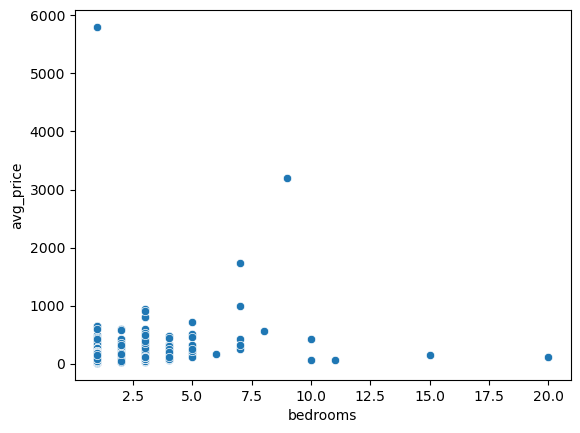

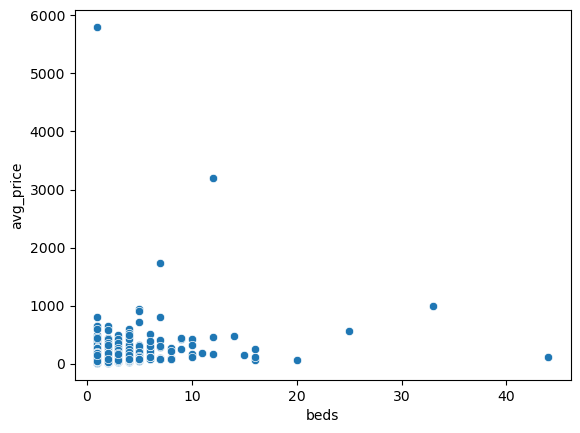

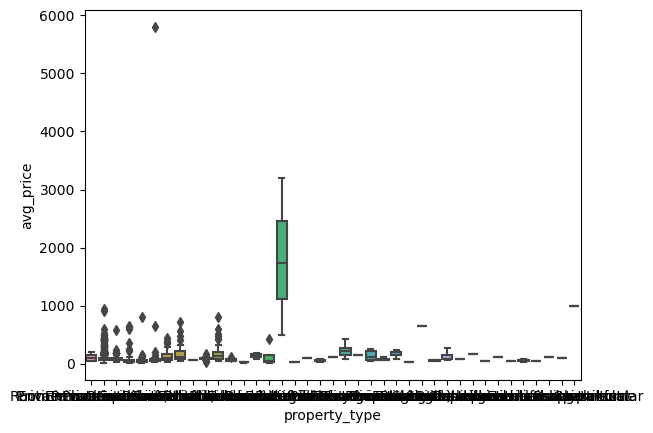

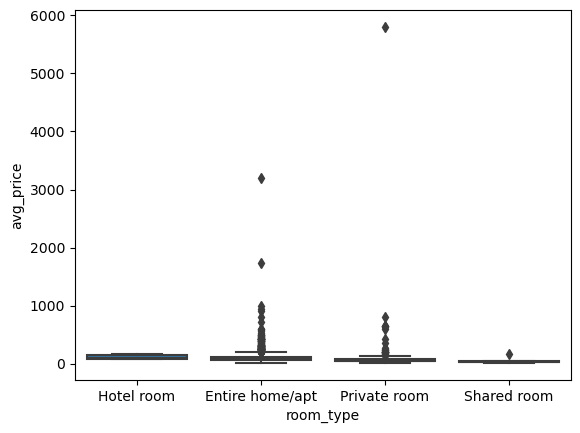

Linear Regression - Validation RMSE: 51.60, Validation R^2: 0.19
Decision Tree - Validation RMSE: 95.21, Validation R^2: -1.74
Random Forest - Validation RMSE: 55.39, Validation R^2: 0.07
Gradient Boosting - Validation RMSE: 56.66, Validation R^2: 0.03
Best Model Test Results - RMSE: 316.38, R^2: 0.02
Top 5 important features:
                       Feature  Importance
17  property_type_Entire villa    0.364569
0                   listing_id    0.186002
1                     bedrooms    0.158965
3                 num_bookings    0.135718
2                         beds    0.075290


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Load data from CSV files
calendar_df = pd.read_csv("C:\\Users\\Anup Jacob\\Downloads\\capstonegroup3\\calendar.csv")
listings_df = pd.read_csv("C:\\Users\\Anup Jacob\\Downloads\\capstonegroup3\\listings.csv") 
hosts_df = pd.read_csv("C:\\Users\\Anup Jacob\\Downloads\\capstonegroup3\\hosts.csv")

# Print column names of listings_df
print("Columns in listings_df:")
print(listings_df.columns)

# Data Understanding and Feature Creation

# Examine Calendar table
print(f"Calendar table shape: {calendar_df.shape}")
print(f"Unique listings in Calendar: {calendar_df['listing_id'].nunique()}")

# Clean price column and convert to float
calendar_df['price'] = calendar_df['price'].astype(str).str.replace('$', '').astype(float)

# Aggregate Calendar data by listing_id
calendar_agg_df = calendar_df.groupby('listing_id').agg(
    avg_price=('price', 'mean'),
    num_bookings=('available', lambda x: sum(x == 0)),
    avg_min_nights=('minimum_nights', 'mean'),
    avg_max_nights=('maximum_nights', 'mean')
).reset_index()

# Select necessary columns from Listings data
listings_cols = ['listing_id', 'bedrooms', 'beds', 'property_type', 'room_type']
listings_subset_df = listings_df[listings_cols]

# Join Listings data 
listings_join_df = pd.merge(listings_subset_df, calendar_agg_df, on='listing_id', how='left')

# Remove the merging step with hosts_df
df = listings_join_df

# Data Quality Checks

# Check for missing values
print(f"Missing values per column:\n{df.isnull().sum()}")

# Descriptive statistics for numeric variables
print(f"Numeric variable statistics:\n{df.describe()}")

# Frequency counts for categorical variables
cat_vars = ['property_type', 'room_type']
for var in cat_vars:
    print(f"Frequency counts for {var}:\n{df[var].value_counts(normalize=True)}")
    
# Drop rows with missing target variable  
df = df.dropna(subset=['avg_price'])

# Variable Profiling & Checking Relationships

# Correlation matrix
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()
print(f"Correlation matrix:\n{corr_matrix}")

# Scatter plots of numeric predictors vs target
num_vars = ['bedrooms', 'beds']
for var in num_vars:
    sns.scatterplot(x=var, y='avg_price', data=df)
    plt.show()
    
# Box plots of categorical predictors vs target  
for var in cat_vars:
    sns.boxplot(x=var, y='avg_price', data=df)
    plt.show()
    
# Drop variables with low correlation to target
drop_vars = ['avg_min_nights', 'avg_max_nights']
df = df.drop(columns=drop_vars)  

# Create dummy variables for categorical predictors
df = pd.get_dummies(df, columns=cat_vars)

# Modeling & Insights

# Split into train, validation and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Separate target variable
y_train, y_val, y_test = train_df['avg_price'], val_df['avg_price'], test_df['avg_price'] 
X_train, X_val, X_test = train_df.drop(columns=['avg_price']), val_df.drop(columns=['avg_price']), test_df.drop(columns=['avg_price'])

# Create an imputer object
imputer = SimpleImputer(strategy='mean')  # or 'median', 'most_frequent'

# Impute missing values in the feature columns
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

# Train and evaluate models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

for name, model in models.items():
    model.fit(X_train_imputed, y_train)
    val_preds = model.predict(X_val_imputed)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    val_r2 = r2_score(y_val, val_preds)
    print(f"{name} - Validation RMSE: {val_rmse:.2f}, Validation R^2: {val_r2:.2f}")

# Pick best model and evaluate on test set    
best_model = RandomForestRegressor(random_state=42)
best_model.fit(X_train_imputed, y_train)
test_preds = best_model.predict(X_test_imputed)
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
test_r2 = r2_score(y_test, test_preds)
print(f"Best Model Test Results - RMSE: {test_rmse:.2f}, R^2: {test_r2:.2f}")

# Get feature importances
importances = best_model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(f"Top 5 important features:\n{importance_df.sort_values('Importance', ascending=False).head(5)}")